In [40]:
import re
import hypertools as hyp
import numpy as np
import pandas as pd

from collections import defaultdict
from difflib import get_close_matches
from IPython.display import display, HTML
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from num2words import num2words as _num2words
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from tqdm.notebook import tqdm

from khan_helpers import Experiment, Participant
from khan_helpers.constants import DATA_DIR, FIG_DIR, RAW_DIR
from khan_helpers.functions import (
    corr_mean,
    interp_lecture,
    parse_windows,
)

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import ConnectionPatch
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

In [2]:
class parrotdict(dict):
    def __missing__(self, key):
        return key

In [3]:
def num2words(num):
    if '^' in num:
        base, power = num.split('^')
        if power == '2':
            exp_phrase = 'squared'
        else:
            exp_phrase = f'to the {num2words(power)}'
        
        words = f'{num2words(base)} {exp_phrase}'
    elif num.endswith('%'):
        words = f'{num2words(num[:-1])} percent'
    else:
        num = num.replace(',', '')
        if num.endswith(('st', 'nd', 'rd', 'th')):
            num = num[:-2]
            to = 'ordinal'
        else:
            to = 'cardinal'
        
        words = _num2words(num, to=to).replace('-', ' ')

    words = words.split()
    while any(w in STOP_WORDS for w in words):
        words.remove(next(w for w in words if w in STOP_WORDS))        

    # remove puncutation & stop word automatically added by num2words
    return ' '.join(words)

In [4]:
def synset_match(word, min_similarity=.6):
    possible_matches = []
    for synset in wordnet.synsets(word):
        for lemma in synset.lemmas():
            possible_matches.append(lemma.name())
            for pert in lemma.pertainyms():
                possible_matches.append(pert.name())

    possible_matches = list(set(possible_matches))
    possible_matches = [m.lower() for m in possible_matches if len(m) <= len(word)]
    # sort by similarity to word
    close_matches = get_close_matches(word, possible_matches, n=2, cutoff=min_similarity)
    if len(close_matches) == 0:
        return word
    # if original word was in synset lemmas and the second closest possibility is shorter, use that
    elif (close_matches[0] == word) and (len(close_matches) > 1) and (len(close_matches[1]) < len(word)):
        return close_matches[1]
    else:
        return close_matches[0]

In [5]:
def preprocess_text(textlist,
                    stop_words=None,
                    lemmatizer=None,
                    tagset_converter=None,
                    man_lemma_sfxs=None,
                    custom_replacements=None):
    # handle defaults
    if stop_words is None:
        stop_words = ()
    if lemmatizer is None:
        lemmatizer = WordNetLemmatizer()
    if tagset_converter is None:
        tagset_converter = parrotdict()
    if man_lemma_sfxs is None:
        man_lemma_sfxs = ()
    if custom_replacements is None:
        custom_replacements = parrotdict()
    
    # indices to map processed words back to correct textlist item
    chunk_ix = [ix for ix, chunk in enumerate(textlist) for _ in chunk.split()]
    processed_chunks = [[] for i in textlist]
    
    # clean spacing, normalize case, strip puncutation
    # (leave punctuation useful for POS tagging or num2words conversion)
    full_text = ' '.join(textlist).lower()
    punc_stripped = re.sub("[^\w\s^'%-]+", '', full_text)
    
    # POS tagging (works better on full transcript - more context provided)
    words_tags = pos_tag(punc_stripped.split())

    for i, (word, tag) in enumerate(words_tags):
        # discard contraction clitics (always stop words) post-tagging
        # irregular stems are (don, isn, etc.) handled by stop word removal
        if "'" in word:
            word = word.split("'")[0]
        
        # skip stop words
        if word in stop_words:
            continue
        
        # convert digits to string representations
        if word[0].isdigit():
            lemma = num2words(word)
        else:
            # convert tagsets
            tag = tagset_converter[tag[0]]
            # lemmatize
            lemma = lemmatizer.lemmatize(word, tag)
            
            # apply custom replacements (no effect on words not in custom_replacements)
            lemma = custom_replacements[lemma]
            
            # handles most cases where the Treebank POS tagger 
            # misidentified the word, causing WordNet's Morphy to use 
            # the wrong syntactic transformation and fail
            if (lemma == word 
                and any(word.endswith(sfx) for sfx in man_lemma_sfxs) 
                and len(word) > 4):
                lemma = synset_match(word)
                if lemma != word:
                    # keep track of changes made this way to spot-check later
                    MANUAL_CHANGES[(word, lemma)] += 1
            
        # split on hyphens, place back in correct text chunk
        processed_chunks[chunk_ix[i]].append(lemma.replace('-', ' '))
        
    # join words within each chunk
    return [' '.join(c) for c in processed_chunks]

In [54]:
class ParamData:
    def __init__(self, n_topics, window_size, corpus_key):
        self.n_topics = n_topics
        self.window_size = window_size
        self.corpus_key = corpus_key
        self.forces_traj = None
        self.bos_traj = None
        self.forces_questions = None
        self.bos_questions = None
        self.gen_questions = None
        self.cv = None
        self.lda = None
        self.score = None
        
    def __str__(self):
        params = f"(n_topics: {self.n_topics}, window_size: {self.window_size}, corpus_key: {self.corpus_key})"
        score = f"score: {self.score}"
        return f"{params}\n{score}"
    
    def __repr_html__(self):
        return str(self)
    
    def __eq__(self, other):
        return self.score == other.score
    
    def __ne__(self, other):
        return self.score != other.score
    
    def __gt__(self, other):
        return self.score > other.score
    
    def __ge__(self, other):
        return self.score >= other.score
    
    def __lt__(self, other):
        return self.score < other.score
    
    def __le__(self, other):
        return self.score <= other.score

    def fit_transform_data(self):
        ff_windows, ff_timestamps = parse_windows(ff_transcript_processed, self.window_size)
        bos_windows, bos_timestamps = parse_windows(bos_transcript_processed, self.window_size)
        ff_question_text = list(quiz_text_processed[:15, 0])
        bos_question_text = list(quiz_text_processed[15:30, 0])
        gen_question_text = list(quiz_text_processed[30:, 0])
        
        corpus = ff_windows + bos_windows + create_qa_corpus(self.corpus_key)
        self.cv = CountVectorizer(**CV_PARAMS)
        self.lda = LatentDirichletAllocation(n_components=self.n_topics, **LDA_PARAMS)
        self.lda.fit(self.cv.fit_transform(corpus))
        
        ff_traj = self.lda.transform(self.cv.transform(ff_windows))
        bos_traj = self.lda.transform(self.cv.transform(bos_windows))
        
        self.forces_traj = interp_lecture(ff_traj, ff_timestamps)
        self.bos_traj = interp_lecture(bos_traj, bos_timestamps)
        self.forces_questions = self.lda.transform(self.cv.transform(ff_question_text))
        self.bos_questions = self.lda.transform(self.cv.transform(bos_question_text))
        self.gen_questions = self.lda.transform(self.cv.transform(gen_question_text))
        
    def score_models(self):
        lecture_questions = np.concatenate((self.forces_questions, self.bos_questions))
        corrs = []
        for ix, lec_traj in enumerate((self.forces_traj, self.bos_traj), start=1):
            props_correct = []
            trace_sums = []
            for p in PARTICIPANTS:
                p_data = p.get_data(lecture=ix, qset=ix)
                acc = p_data['accuracy']
                props_correct.append(acc.sum() / len(acc))
                qs_seen = lecture_questions[p_data['qID'] - 1]
                trace = reconstruct_trace(lec_traj, qs_seen, acc)
                trace_sums.append(trace.sum())
                
            corrs.append(pearsonr(props_correct, trace_sums)[0])
        self.score = corr_mean(corrs)
        
    def plot_topics(self, y_max=0.2):
        sns.set_style('ticks')
        fig, axarr = plt.subplots(2, 3)
        fig.set_size_inches(15, 10)
        axarr = axarr.flatten()

        for i, traj in enumerate([self.forces_traj, 
                                  self.bos_traj, 
                                  None, 
                                  self.forces_questions, 
                                  self.bos_questions, 
                                  self.gen_questions]):
            ax = axarr[i]
            if traj is None:
                ax.axis('off')
                continue

            topic_vars = np.var(traj, axis=0)
            bars = ax.bar(x=list(range(1, len(topic_vars)+1)), 
                          height=topic_vars, 
                          color=sns.color_palette('hls', len(topic_vars)))
            ax.set_ylim(0, y_max)
            ax.set_xlim(.5, len(topic_vars)+.5)
            ax.set_xticks(list(range(2, len(topic_vars)+1, 2)))
            if i == 0:
                ax.set_ylabel('Mean topic activation', fontsize='x-large')
                ax.set_title('Four Forces', fontsize='xx-large')
                ax.annotate('Lectures', xy=(-.5, .5), xycoords=ax.yaxis.label, 
                            size='xx-large', rotation=90, ha='right', va='center')
            elif i == 1:
                ax.set_title('Birth of Stars', fontsize='xx-large')
            elif i == 3:
                ax.set_ylabel('Mean topic activation', fontsize='x-large')
                ax.annotate('Questions', xy=(-.5, .5), xycoords=ax.yaxis.label, 
                            size='xx-large', rotation=90, ha='right', va='center')
            elif i == 5:
                ax.set_title('General Knowledge', fontsize='xx-large')
            if i > 2:
                ax.set_xlabel('Topic dimension', fontsize='x-large')
        plt.tight_layout()
        plt.show()
        
    def plot_heatmaps(self):
        plt.rcParams['pdf.fonttype'] = 42
        sns.set_context('paper')
        cmap = 'rocket'
        gridspec_kws = {
            'wspace': 0.1, 
            'hspace': 0.3, 
            'width_ratios': (1, 1, .3, 1)
        }
        cbar_kws = {'pad': 0.1}
        ff_traj = self.forces_traj
        bos_traj = self.bos_traj
        forces_qs = self.forces_questions
        bos_qs = self.bos_questions
        fig, axarr = plt.subplots(2, 4, gridspec_kw=gridspec_kws)
        fig.set_size_inches(12, 6)
        ((a, b, sep1, c), (d, e, sep2, f)) = axarr
        sns.heatmap(ff_traj, vmin=0, vmax=1, xticklabels=2, yticklabels=100, 
                    cbar=False, cmap=cmap, ax=a)
        a.collections[0].remove()
        aspect = ff_traj.shape[1] / ff_traj.shape[0]
        a.imshow(ff_traj, aspect=aspect, vmin=0, vmax=1, cmap=cmap)
        a.set_title('Lecture\ntopic proportions', fontsize=12)
        a.set_ylabel('Timepoint (s)', fontsize=12)
        a.annotate('Four Forces', xy=(-.75, .5), xycoords=a.yaxis.label, 
                   size='xx-large', rotation=90, ha='right', va='center')
        corrmat = np.corrcoef(ff_traj)
        sns.heatmap(corrmat, vmin=0, vmax=1, xticklabels=100, yticklabels=100, 
                    cbar=False, cmap=cmap, ax=b)
        b.collections[0].remove()
        b.imshow(corrmat, aspect='equal', vmin=0, vmax=1, cmap=cmap)
        b.set_title('Lecture\ncorrelation matrix', fontsize=12)
        sns.heatmap(forces_qs, vmin=0, vmax=1, xticklabels=2, yticklabels=2, 
                    cmap=cmap, cbar=True, cbar_kws=cbar_kws, ax=c)
        c.collections[0].remove()
        aspect = forces_qs.shape[1] / forces_qs.shape[0]
        c.imshow(forces_qs, aspect=aspect, vmin=0, vmax=1, cmap=cmap)
        c.set_yticklabels(list(range(1, 16, 2)), rotation=0)
        c.set_title('Question\ntopic proportions', fontsize=12)
        c.set_ylabel('Question', fontsize=12)
        sns.heatmap(bos_traj, vmin=0, vmax=1, xticklabels=2, yticklabels=100, 
                    cbar=False, cmap=cmap, ax=d)
        d.collections[0].remove()
        aspect = bos_traj.shape[1] / bos_traj.shape[0]
        d.imshow(bos_traj, aspect=aspect, vmin=0, vmax=1, cmap=cmap)
        d.set_xlabel('Topic', fontsize=12)
        d.set_ylabel('Timepoint (s)', fontsize=12)
        d.annotate('Birth of Stars', xy=(-.75, .5), xycoords=d.yaxis.label, 
                   size='xx-large', rotation=90, ha='right', va='center')
        corrmat = np.corrcoef(bos_traj)
        sns.heatmap(corrmat, vmin=0, vmax=1, xticklabels=100, yticklabels=100, 
                    cbar=False, cmap=cmap, ax=e)
        e.collections[0].remove()
        e.imshow(corrmat, aspect='equal', vmin=0, vmax=1, cmap=cmap)
        e.set_xlabel('Timepoint (s)', fontsize=12)
        sns.heatmap(bos_qs, vmin=0, vmax=1, xticklabels=2, yticklabels=2, 
                    cmap=cmap, cbar=True, cbar_kws=cbar_kws, ax=f)
        f.collections[0].remove()
        aspect = bos_qs.shape[1] / bos_qs.shape[0]
        f.imshow(bos_qs, aspect=aspect, vmin=0, vmax=1, cmap=cmap)
        f.set_yticklabels(list(range(16, 31, 2)), rotation=0)
        f.set_xlabel('Topic', fontsize=12)
        f.set_ylabel('Question', fontsize=12)
        xyA = (0, 1)
        xyB = (0, 0)
        vline = ConnectionPatch(xyA, xyB, coordsA='axes fraction', 
                                coordsB='axes fraction', axesA=sep1, axesB=sep2, 
                                linestyle='--', linewidth=1.5, color='grey')
        sep2.add_artist(vline)
        sep1.axis('off')
        sep2.axis('off')
        labels = 'ABCDEF'
        for i, ax in enumerate((a, b, c, d, e, f)):
            ax.text(-.1, 1.07, labels[i], horizontalalignment='center', 
                    transform=ax.transAxes, fontsize=12)
        plt.show()
        
    def plot_corr_timeseries(self):
        sns.set_context('talk')
        sns.set_palette(sns.hls_palette(15, h=.3))
        ff_traj = self.forces_traj
        bos_traj = self.bos_traj
        forces_qs = self.forces_questions
        bos_qs = self.bos_questions
        forces_qcorrs = 1 - cdist(ff_traj, forces_qs, 'correlation')
        bos_qcorrs = 1 - cdist(bos_traj, bos_qs, 'correlation')
        # choose some sample points to compare lecture & question content
        forces_high = [117, 537]
        forces_low = [252, 384]
        bos_high = [167, 455]
        bos_low = [102, 430]
        fig, axarr = plt.subplots(1, 2, sharey=True)
        fig.set_size_inches(20, 7)
        fax, bax = axarr
        fax.plot(forces_qcorrs)
        fax.set_xlim(0, ff_traj.shape[0])
        fax.set_ylim(-.2, 1.05)
        fax.set_xlabel('Lecture timepoint (s)')
        fax.set_ylabel('Topic vector correlation')
        fax.set_title('Four Forces', pad=20)
        fax.legend(labels=[f'Q {i}' for i in range(1, 16)], fontsize=12, loc=8, 
                   ncol=8, bbox_to_anchor=(.5, -.4))
        fax.grid(False)
        fax.text(0, 1.03, 'A', horizontalalignment='left', transform=fax.transAxes)
        bax.plot(bos_qcorrs)
        bax.set_xlim(0, bos_traj.shape[0])
        bax.set_ylim(-.2, 1.05)
        bax.set_xlabel('Lecture timepoint (s)')
        bax.set_title('Birth of Stars', pad=20)
        bax.legend(labels=[f'Q {i}' for i in range(16, 31)], fontsize=11.5, loc=8, 
                   ncol=8, bbox_to_anchor=(.5, -.4))
        bax.grid(False)
        bax.text(0, 1.03, 'B', horizontalalignment='left', transform=bax.transAxes)
        plt.subplots_adjust(wspace=-1)
        plt.tight_layout()
        plt.show()
    
    def plot_hypertools(self, ndims=3, reducer='IncrementalPCA', **hyp_kwargs):
        sns.reset_defaults()
        ff_traj = self.forces_traj
        bos_traj = self.bos_traj
        ff_qs_vecs = self.forces_questions
        bos_qs_vecs = self.bos_questions
        gen_qs_vecs = self.gen_questions
        fig, axarr = plt.subplots(3, 3, subplot_kw={'projection': '3d'}, gridspec_kw={'wspace': -.1, 'hspace': -.1})
        fig.set_size_inches(15, 10)
        axarr = axarr.flatten()
        for ax, azim in zip(axarr, range(0, 360, 45)):
            ax = hyp.plot([ff_traj, bos_traj, ff_qs_vecs, bos_qs_vecs, gen_qs_vecs], 
                          fmt=['r-', 'g-', 'bo', 'yo', 'ko'], 
                          ndims=ndims, 
                          reduce=reducer, 
                          azim=azim, 
                          show=False, 
                          ax=ax, **hyp_kwargs)
        axarr[-1].axis('off')
        fig.legend(['Four Forces lecture', 'Birth of Stars lecture', 
                    'Four Forces questions', 'Birth of Stars questions', 'general knowledge questions'],
                   loc='lower right', bbox_to_anchor=(.78, .09), fontsize='x-large')
        return fig
    
    def plot_qcorr_dists(self, n_bins=20, x_min=-1, x_max=1):
        forces_qcorrs = np.corrcoef(self.forces_questions)
        bos_qcorrs = np.corrcoef(self.bos_questions)
        plt.hist(forces_qcorrs[np.triu_indices_from(forces_qcorrs, k=1)], bins=n_bins)
        plt.xlim(x_min, x_max)
        plt.title('Four Forces')
        plt.show()
        plt.hist(bos_qcorrs[np.triu_indices_from(bos_qcorrs, k=1)], bins=n_bins)
        plt.xlim(x_min, x_max)
        plt.title('Birth of Stars')
        plt.show()

In [7]:
def create_qa_corpus(corpus_key):
    qa_corpus = []
    if 'Q' in corpus_key:
        # include all questions
        q_rows = quiz_text_processed[:]
    elif 'q' in corpus_key:
        # include lecture-related questions
        q_rows = quiz_text_processed[:30]
    else:
        # no questions (or answers) included
        return []
    
    qa_corpus.extend(q_rows[:, 0])
    
    if 'A' in corpus_key:
        # all answer choices
        qa_corpus.extend(q_rows[:, 1:].ravel())
    elif 'a' in corpus_key:
        # correct answers only
        qa_corpus.extend(q_rows[:, 1])
        
    return qa_corpus

In [8]:
def reconstruct_trace(lecture, questions, acc):
    acc = np.array(acc, dtype=bool)
    wz = 1 - cdist(lecture, questions, metric='correlation')
    wz -= wz.min()
    wz /= wz.max()
    a = wz.sum(axis=1)
    b = wz[:, acc].sum(axis=1)
    return b / a

In [9]:
exp = Experiment()

STOP_WORDS = stopwords.words('english') + ['bit', 'even', 'get', 'like', 
                                           'really', 'saw', 'see', 'seen', 
                                           'thing', 'things', 'us', 'would']

LEMMATIZER = WordNetLemmatizer()

MAN_LEMMATIZE_SFXS = ['s', 'ing', 'ly', 'ed', 'er', 'est']

CUSTOM_REPLACEMENTS = {'mc^2': 'mc squared'}
CUSTOM_REPLACEMENTS = parrotdict(**CUSTOM_REPLACEMENTS)

POS_MAPPING = defaultdict(lambda: 'n')
for tb_tag, wn_tag in zip(['N', 'P', 'V', 'J', 'D', 'R'],
                          ['n', 'n', 'v', 'a', 'a', 'r']):
    POS_MAPPING[tb_tag] = wn_tag
    
MANUAL_CHANGES = defaultdict(lambda: 0)

In [10]:
CV_PARAMS = {
    'strip_accents': 'unicode',
    'stop_words': None  # stop words are removed during preprocessing
}

LDA_PARAMS = {
    'learning_method': 'batch',
    'random_state': 0
}

In [11]:
ff_lines = exp.forces_transcript.splitlines()
ff_timestamps = ff_lines[::2]
ff_text_lines = ff_lines[1::2]
ff_lines_processed = preprocess_text(ff_text_lines, 
                                     stop_words=STOP_WORDS, 
                                     lemmatizer=LEMMATIZER, 
                                     tagset_converter=POS_MAPPING, 
                                     man_lemma_sfxs=MAN_LEMMATIZE_SFXS, 
                                     custom_replacements=CUSTOM_REPLACEMENTS)
ff_transcript_processed = []
for ts_line, txt_line in zip(ff_timestamps, ff_lines_processed):
    ff_transcript_processed.append(f'{ts_line}\n{txt_line}')
ff_transcript_processed = '\n'.join(ff_transcript_processed)


bos_lines = exp.bos_transcript.splitlines()
bos_timestamps = bos_lines[::2]
bos_text_lines = bos_lines[1::2]
bos_lines_processed = preprocess_text(bos_text_lines, 
                                      stop_words=STOP_WORDS, 
                                      lemmatizer=LEMMATIZER, 
                                      tagset_converter=POS_MAPPING, 
                                      man_lemma_sfxs=MAN_LEMMATIZE_SFXS, 
                                      custom_replacements=CUSTOM_REPLACEMENTS)
bos_transcript_processed = []
for ts_line, txt_line in zip(bos_timestamps, bos_lines_processed):
    bos_transcript_processed.append(f'{ts_line}\n{txt_line}')
bos_transcript_processed = '\n'.join(bos_transcript_processed)

In [12]:
quiz_text = exp.questions.values[:, 1:]
quiz_text_processed = preprocess_text(quiz_text.ravel(), 
                                      stop_words=STOP_WORDS, 
                                      lemmatizer=LEMMATIZER, 
                                      tagset_converter=POS_MAPPING, 
                                      man_lemma_sfxs=MAN_LEMMATIZE_SFXS, 
                                      custom_replacements=CUSTOM_REPLACEMENTS)
quiz_text_processed = np.reshape(quiz_text_processed, quiz_text.shape)
question_text = quiz_text_processed[:, 0]


In [13]:
PARTICIPANTS = []
raw_data = pd.read_csv(RAW_DIR.joinpath('psiturk-data-raw.tsv'), 
                       sep='\t', 
                       index_col='Unnamed: 0')
for ix, row in raw_data.iterrows():
    p = Participant.from_psiturk(row, subid=f"P{ix + 1}")
    PARTICIPANTS.append(p)

In [55]:
# (maximum) number of topics to fit the topic model
n_topics = [10, 15, 20]

# length of lecture transcript sliding window
lecture_wsize = [10, 15, 20]

# training corpus for topic model
# - l: lecture sliding windows
# - q: lecture-related multiple choice questions' text
# - Q: all multiple choice questions' text
# - a: correct responses to multiple choice questions
# - A: all options for responses to multiple choice questions
corpora = ['l', 'lq', 'lQ', 'lqa', 'lQa', 'lqA', 'lQA']

param_grid = [(t, w, c) for t in n_topics for w in lecture_wsize for c in corpora]

In [56]:
PARAM_OBJS = []

def model_params(n_topics, wsize, corpus):
    for obj in PARAM_OBJS:
        if (obj.n_topics == n_topics and 
            obj.window_size == wsize and 
            obj.corpus_key == corpus):
            return obj
        
    new_obj = ParamData(n_topics, wsize, corpus)
    new_obj.fit_transform_data()
    new_obj.score_models()
    PARAM_OBJS.append(new_obj)
    return new_obj

In [57]:
for params in tqdm(param_grid):
    model_params(*params)

In [191]:
test = model_params(3, 30, 'lqa')

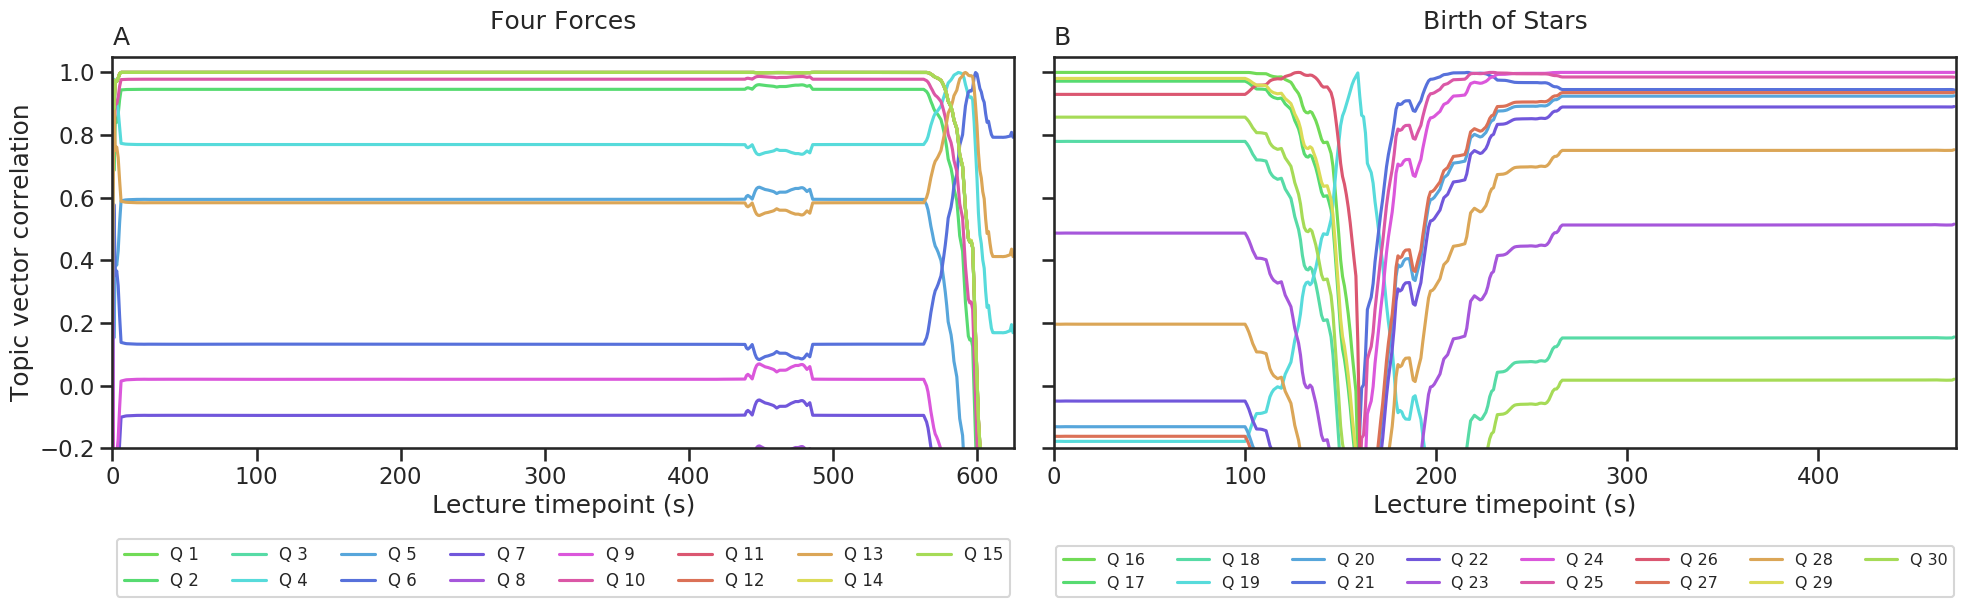

In [194]:
test.plot_corr_timeseries()